## Домашнее задание
2 варианта.
1. Вариант легкий: Решите задачу классификации цветков ирисов с использованием PySpark
2. Вариант сложный: Решите задачу классификации пассажиров титаника с использованием PySpark (https://www.kaggle.com/c/titanic)

**При выполнении ДЗ не разрешается:**
1. Использовать библиотеку pandas
2. Использовать библиотеку sklearn

Полезные импорты:
1. from pyspark.ml.classification import LogisticRegression
2. from pyspark.ml.evaluation import MulticlassClassificationEvaluator - для оценки качества работы алгоритма
3. from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler - для предобработки признаков

Полезные ссылки:
1. https://spark.apache.org/docs/latest/ml-classification-regression.html#classification - алгоримты классификации в pyspark
2. https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa - пример решения задачи классификации на pyspark

In [ ]:
!pip install pyspark

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window

In [317]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [42]:
w = Window().orderBy(F.lit('A'))

In [199]:
df = spark.read.csv('data.csv', header=True)
df = df.drop('PassengerId', 'Ticket', 'Cabin', 'Name')
df.show(5)

+--------+------+------+---+-----+-----+-------+--------+
|Survived|Pclass|   Sex|Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+---+-----+-----+-------+--------+
|       0|     3|  male| 22|    1|    0|   7.25|       S|
|       1|     1|female| 38|    1|    0|71.2833|       C|
|       1|     3|female| 26|    0|    0|  7.925|       S|
|       1|     1|female| 35|    1|    0|   53.1|       S|
|       0|     3|  male| 35|    0|    0|   8.05|       S|
+--------+------+------+---+-----+-----+-------+--------+
only showing top 5 rows



In [115]:
df.select([F.count(c) for c in df.columns]).show(5)

+---------------+-------------+----------+----------+------------+------------+-----------+---------------+
|count(Survived)|count(Pclass)|count(Sex)|count(Age)|count(SibSp)|count(Parch)|count(Fare)|count(Embarked)|
+---------------+-------------+----------+----------+------------+------------+-----------+---------------+
|            891|          891|       891|       714|         891|         891|        891|            889|
+---------------+-------------+----------+----------+------------+------------+-----------+---------------+



In [116]:
df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(f'na({c})') for c in df.columns]).show(5)

+------------+----------+-------+-------+---------+---------+--------+------------+
|na(Survived)|na(Pclass)|na(Sex)|na(Age)|na(SibSp)|na(Parch)|na(Fare)|na(Embarked)|
+------------+----------+-------+-------+---------+---------+--------+------------+
|           0|         0|      0|    177|        0|        0|       0|           2|
+------------+----------+-------+-------+---------+---------+--------+------------+



In [200]:
mean_age = df.select(F.mean(df.Age)).take(1)[0][0]
mode_embark = df.select(F.mode(df.Embarked)).take(1)[0][0]

In [118]:
mean_age, mode_embark

(29.69911764705882, 'S')

In [201]:
df = df.fillna({'Age': mean_age, 'Embarked': mode_embark})
df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(f'na({c})') for c in df.columns]).show(5)


+------------+----------+-------+-------+---------+---------+--------+------------+
|na(Survived)|na(Pclass)|na(Sex)|na(Age)|na(SibSp)|na(Parch)|na(Fare)|na(Embarked)|
+------------+----------+-------+-------+---------+---------+--------+------------+
|           0|         0|      0|      0|        0|        0|       0|           0|
+------------+----------+-------+-------+---------+---------+--------+------------+



In [202]:
sex_indexer = StringIndexer(inputCol='Sex', outputCol='Sex_').fit(df)
embarked_indexer = StringIndexer(inputCol='Embarked', outputCol='Embarked_').fit(df)

In [203]:
df = (sex_indexer
    .transform(df)
    .drop('Sex')
    .withColumnRenamed('Sex_', 'Sex')
)
df = (embarked_indexer
    .transform(df)
    .drop('Embarked')
    .withColumnRenamed('Embarked_', 'Embarked')
)
df.show(5)

+--------+------+---+-----+-----+-------+---+--------+
|Survived|Pclass|Age|SibSp|Parch|   Fare|Sex|Embarked|
+--------+------+---+-----+-----+-------+---+--------+
|       0|     3| 22|    1|    0|   7.25|0.0|     0.0|
|       1|     1| 38|    1|    0|71.2833|1.0|     1.0|
|       1|     3| 26|    0|    0|  7.925|1.0|     0.0|
|       1|     1| 35|    1|    0|   53.1|1.0|     0.0|
|       0|     3| 35|    0|    0|   8.05|0.0|     0.0|
+--------+------+---+-----+-----+-------+---+--------+
only showing top 5 rows



In [204]:
encoder = OneHotEncoder(inputCol='Embarked', outputCol='Embarked_', dropLast=False).fit(df)

In [205]:
emb_labels = embarked_indexer.labels

In [206]:
df1 = (encoder
    .transform(df)
    # .drop('Sex')
    # .withColumnRenamed('Sex_', 'Sex')
    # .show(5)
)
df1 = df1.select('*', vector_to_array('Embarked_').alias('emb_ar'))
emb_len = len(df1.first()['emb_ar'])
cols = [F.col('emb_ar')[i].alias(f'emb_{emb_labels[i]}') for i in range(emb_len)]
df = df1.select('*', *cols).drop('Embarked', 'Embarked_', 'emb_ar')

In [207]:
df1 = df
df.show(5)

+--------+------+---+-----+-----+-------+---+-----+-----+-----+
|Survived|Pclass|Age|SibSp|Parch|   Fare|Sex|emb_S|emb_C|emb_Q|
+--------+------+---+-----+-----+-------+---+-----+-----+-----+
|       0|     3| 22|    1|    0|   7.25|0.0|  1.0|  0.0|  0.0|
|       1|     1| 38|    1|    0|71.2833|1.0|  0.0|  1.0|  0.0|
|       1|     3| 26|    0|    0|  7.925|1.0|  1.0|  0.0|  0.0|
|       1|     1| 35|    1|    0|   53.1|1.0|  1.0|  0.0|  0.0|
|       0|     3| 35|    0|    0|   8.05|0.0|  1.0|  0.0|  0.0|
+--------+------+---+-----+-----+-------+---+-----+-----+-----+
only showing top 5 rows



In [208]:
df.dtypes

[('Survived', 'string'),
 ('Pclass', 'string'),
 ('Age', 'string'),
 ('SibSp', 'string'),
 ('Parch', 'string'),
 ('Fare', 'string'),
 ('Sex', 'double'),
 ('emb_S', 'double'),
 ('emb_C', 'double'),
 ('emb_Q', 'double')]

In [209]:
df = df.select([df[c].cast("float") for c in df.columns])
df.dtypes

[('Survived', 'float'),
 ('Pclass', 'float'),
 ('Age', 'float'),
 ('SibSp', 'float'),
 ('Parch', 'float'),
 ('Fare', 'float'),
 ('Sex', 'float'),
 ('emb_S', 'float'),
 ('emb_C', 'float'),
 ('emb_Q', 'float')]

In [274]:
df.printSchema()

root
 |-- Survived: float (nullable = true)
 |-- Pclass: float (nullable = true)
 |-- Age: float (nullable = true)
 |-- SibSp: float (nullable = true)
 |-- Parch: float (nullable = true)
 |-- Fare: float (nullable = true)
 |-- Sex: float (nullable = false)
 |-- emb_S: float (nullable = true)
 |-- emb_C: float (nullable = true)
 |-- emb_Q: float (nullable = true)



Через отдельные столбцы

In [236]:
x_col = df.drop('Survived').columns
x_col

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'emb_S', 'emb_C', 'emb_Q']

In [237]:
assembler = [VectorAssembler(inputCols=[col], outputCol=col + '_vec') for col in x_col]

In [238]:
scaler = [MinMaxScaler(inputCol=col + '_vec', outputCol= col + '_scaled') for col in x_col]

In [239]:
pipeline = Pipeline(stages= assembler + scaler)

In [240]:
df1 = pipeline.fit(df).transform(df)

In [241]:
# x_vect = x_vect.select('features')
df1.show(5)

+--------+------+----+-----+-----+-------+---+-----+-----+-----+----------+-------+---------+---------+--------------------+-------+---------+---------+---------+-------------+--------------------+------------+------------+--------------------+----------+------------+------------+------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Sex|emb_S|emb_C|emb_Q|Pclass_vec|Age_vec|SibSp_vec|Parch_vec|            Fare_vec|Sex_vec|emb_S_vec|emb_C_vec|emb_Q_vec|Pclass_scaled|          Age_scaled|SibSp_scaled|Parch_scaled|         Fare_scaled|Sex_scaled|emb_S_scaled|emb_C_scaled|emb_Q_scaled|
+--------+------+----+-----+-----+-------+---+-----+-----+-----+----------+-------+---------+---------+--------------------+-------+---------+---------+---------+-------------+--------------------+------------+------------+--------------------+----------+------------+------------+------------+
|     0.0|   3.0|22.0|  1.0|  0.0|   7.25|0.0|  1.0|  0.0|  0.0|     [3.0]| [22.0]|    [1.0]|    [0.0]|            

Сразу через вектор

In [257]:
x_vect = VectorAssembler(inputCols=x_col, outputCol='features').transform(df)
x_vect.show(5)

+--------+------+----+-----+-----+-------+---+-----+-----+-----+--------------------+
|Survived|Pclass| Age|SibSp|Parch|   Fare|Sex|emb_S|emb_C|emb_Q|            features|
+--------+------+----+-----+-----+-------+---+-----+-----+-----+--------------------+
|     0.0|   3.0|22.0|  1.0|  0.0|   7.25|0.0|  1.0|  0.0|  0.0|[3.0,22.0,1.0,0.0...|
|     1.0|   1.0|38.0|  1.0|  0.0|71.2833|1.0|  0.0|  1.0|  0.0|[1.0,38.0,1.0,0.0...|
|     1.0|   3.0|26.0|  0.0|  0.0|  7.925|1.0|  1.0|  0.0|  0.0|[3.0,26.0,0.0,0.0...|
|     1.0|   1.0|35.0|  1.0|  0.0|   53.1|1.0|  1.0|  0.0|  0.0|[1.0,35.0,1.0,0.0...|
|     0.0|   3.0|35.0|  0.0|  0.0|   8.05|0.0|  1.0|  0.0|  0.0|(9,[0,1,4,6],[3.0...|
+--------+------+----+-----+-----+-------+---+-----+-----+-----+--------------------+
only showing top 5 rows



In [244]:
train_df, test_df = x_vect.randomSplit([0.8, 0.2])

In [254]:
train_df.select(train_df.features)

DataFrame[features: vector]

In [275]:
scaler = MinMaxScaler(inputCol='features', outputCol='features_scaled').fit(train_df)
train_scaled = scaler.transform(train_df).select('Survived', 'features_scaled')
test_scaled = scaler.transform(test_df).select('Survived', 'features_scaled')
train_scaled.show(5)

+--------+--------------------+
|Survived|     features_scaled|
+--------+--------------------+
|     0.0|(9,[1,4,6],[0.359...|
|     0.0|(9,[1,4,6],[0.367...|
|     0.0|(9,[1,4,6],[0.367...|
|     0.0|(9,[1,4,6],[0.367...|
|     0.0|(9,[1,4,6],[0.367...|
+--------+--------------------+
only showing top 5 rows



In [276]:
test_scaled.show(5)

+--------+--------------------+
|Survived|     features_scaled|
+--------+--------------------+
|     0.0|(9,[1,4,6],[0.346...|
|     0.0|(9,[1,4,6],[0.367...|
|     0.0|(9,[1,4,6],[0.748...|
|     0.0|(9,[0,1,4,6],[0.5...|
|     0.0|(9,[0,1,4,6],[0.5...|
+--------+--------------------+
only showing top 5 rows



In [270]:
train_scaled.select(vector_to_array(train_scaled['features_scaled'])).first()

Row(UDF(features_scaled)=[0.0, 0.35913546127674884, 0.0, 0.0, 0.05855609755632653, 0.0, 1.0, 0.0, 0.0])

In [277]:
log_reg = LogisticRegression(featuresCol='features_scaled', labelCol='Survived')

In [282]:
log_reg_fit = log_reg.fit(train_scaled)

In [283]:
log_reg_fit.intercept, log_reg_fit.coefficients

(1.3204834570985313,
 DenseVector([-1.9055, -3.6791, -3.2531, -0.8366, 1.289, 2.747, -0.213, 0.2118, 0.1265]))

In [286]:
log_reg_fit.summary.accuracy

0.8027972027972028

In [292]:
log_reg_fit.summary.roc.show(5)

+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|                 0.0|0.003558718861209...|
|                 0.0|0.007117437722419...|
|                 0.0|0.010676156583629894|
|0.002304147465437788|0.010676156583629894|
+--------------------+--------------------+
only showing top 5 rows



In [294]:
 roc_df = log_reg_fit.summary.roc.toPandas()

In [ ]:
import seaborn as sns

<Axes: xlabel='FPR', ylabel='TPR'>

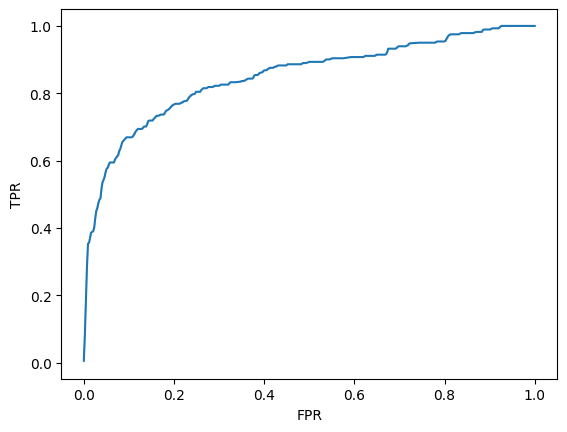

In [298]:
sns.lineplot(x = roc_df.FPR, y = roc_df.TPR)

In [299]:
log_reg_fit.summary.areaUnderROC

0.8494842317595159

In [302]:
log_reg_fit.summary.predictions.show(5)

+--------+--------------------+--------------------+--------------------+----------+
|Survived|     features_scaled|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+--------------------+----------+
|     0.0|(9,[1,4,6],[0.359...|[0.13833879356340...|[0.53452964800196...|       0.0|
|     0.0|(9,[1,4,6],[0.367...|[0.18091227706761...|[0.54510511493188...|       0.0|
|     0.0|(9,[1,4,6],[0.367...|[0.18072357839284...|[0.54505832376713...|       0.0|
|     0.0|(9,[1,4,6],[0.367...|[0.17933980410724...|[0.54471516826581...|       0.0|
|     0.0|(9,[1,4,6],[0.367...|[0.16814379470988...|[0.54193719001085...|       0.0|
+--------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [304]:
pred_res = log_reg_fit.transform(test_scaled)

In [305]:
pred_res.show()

+--------+--------------------+--------------------+--------------------+----------+
|Survived|     features_scaled|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+--------------------+----------+
|     0.0|(9,[1,4,6],[0.346...|[0.04908486666142...|[0.51226875348061...|       0.0|
|     0.0|(9,[1,4,6],[0.367...|[0.13946188407369...|[0.53480907070719...|       0.0|
|     0.0|(9,[1,4,6],[0.748...|[1.58018203312842...|[0.82923029676265...|       0.0|
|     0.0|(9,[0,1,4,6],[0.5...|[0.50016054005830...|[0.62249705796973...|       0.0|
|     0.0|(9,[0,1,4,6],[0.5...|[0.62910405382947...|[0.65228628137329...|       0.0|
|     0.0|(9,[0,1,4,6],[0.5...|[0.62910405382947...|[0.65228628137329...|       0.0|
|     0.0|(9,[0,1,4,6],[0.5...|[0.86277536329256...|[0.70324018094543...|       0.0|
|     0.0|(9,[0,1,4,6],[0.5...|[0.85648547145108...|[0.70192584599157...|       0.0|
|     0.0|(9,[0,1,4,6],[0.5...|[0.94894761254168...|[0.7209034851

In [306]:
eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Survived')
eval.evaluate(pred_res)


0.7828937990021384

In [315]:
eval = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='Survived')

In [316]:
eval.evaluate(pred_res)

0.806041013584117